Importando librerías

In [19]:
import tensorflow as tf
from tensorflow.keras import models,layers
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

In [20]:
IMAGE_SIZE = (256,256)
BATCH_SIZE = 32

Importando imágenes

In [21]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r"C:\Users\lenovo\OneDrive - ITESO\Documentos\ITESO - Data Science\Semestre 3 - IDI2\Projecto Final Maiz\archive (5)\data",
    shuffle=True,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

Found 2315 files belonging to 4 classes.


In [22]:
class_names = dataset.class_names
class_names

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

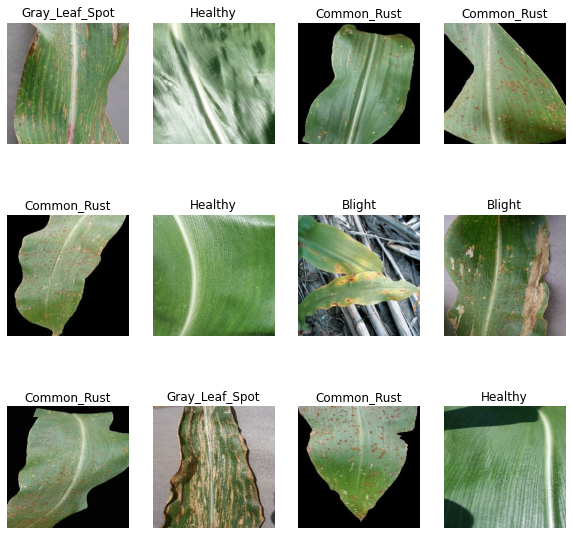

In [23]:
plt.figure(figsize=(10,10))
for image_batch , label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

Data Augmentation

In [24]:
def get_dataset(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=8)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size) 
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [25]:
train_ds,val_ds,test_ds = get_dataset(dataset)

In [26]:
print("Length of Training Dataset is",len(train_ds))
print("\nLength of Validation Dataset is",len(val_ds))
print("\nLength of Testing Dataset is",len(test_ds))

Length of Training Dataset is 58

Length of Validation Dataset is 7

Length of Testing Dataset is 8


In [27]:
# optimizaciones adicionales a los conjuntos de datos de entrenamiento, validación y prueba creados por la función get_dataset()
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [28]:
resize_and_rescale = tf.keras.Sequential([
layers.experimental.preprocessing.Resizing(256,256),
layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [29]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

Modelo CNN

In [30]:
n_classes = 4
input_shape = (BATCH_SIZE,256,256,3)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation ='relu',input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),
    
])
model.build(input_shape=input_shape)

In [31]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_4 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_5 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_5 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [32]:
model.compile(
optimizer='adam',
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
metrics=['accuracy']
)

Fitting

In [33]:
history = model.fit(
train_ds,
epochs=40,
batch_size=BATCH_SIZE,
verbose=1,
validation_data=val_ds)

Epoch 1/40
58/58 [==============================] - 344s 6s/step - loss: 0.9990 - accuracy: 0.5406 - val_loss: 0.5990 - val_accuracy: 0.7366
Epoch 2/40
58/58 [==============================] - 301s 5s/step - loss: 0.6029 - accuracy: 0.7504 - val_loss: 0.5338 - val_accuracy: 0.7902
Epoch 3/40
58/58 [==============================] - 274s 5s/step - loss: 0.5354 - accuracy: 0.7869 - val_loss: 0.4620 - val_accuracy: 0.7545
Epoch 4/40
58/58 [==============================] - 251s 4s/step - loss: 0.5067 - accuracy: 0.7907 - val_loss: 0.6419 - val_accuracy: 0.7500
Epoch 5/40
58/58 [==============================] - 266s 5s/step - loss: 0.4711 - accuracy: 0.7984 - val_loss: 0.4517 - val_accuracy: 0.7679
Epoch 6/40
58/58 [==============================] - 232s 4s/step - loss: 0.4403 - accuracy: 0.8082 - val_loss: 0.4007 - val_accuracy: 0.8214
Epoch 7/40
58/58 [==============================] - 201s 3s/step - loss: 0.4406 - accuracy: 0.8245 - val_loss: 0.3895 - val_accuracy: 0.8214
Epoch 8/40
58

In [34]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 24s 656ms/step - loss: 0.2832 - accuracy: 0.8906


In [35]:
history.params

{'verbose': 1, 'epochs': 40, 'steps': 58}

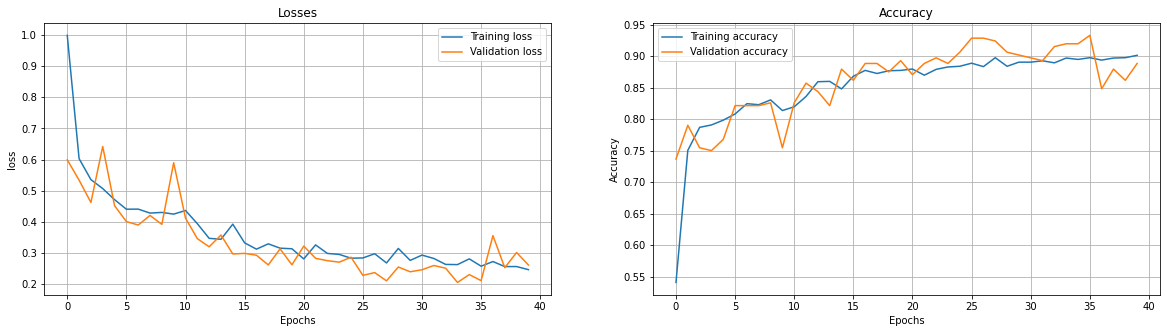

In [36]:
his_data = pd.DataFrame(history.history)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(his_data.loss, label="Training loss")
plt.plot(his_data.val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Losses")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(his_data.accuracy, label="Training accuracy")
plt.plot(his_data.val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()

First Image to Predict :

Actual label: Blight
1/1 [==============================] - 1s 1s/step

Predicted label Blight


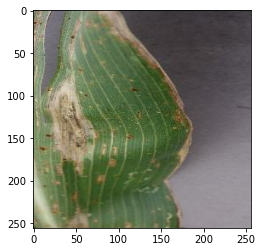

In [37]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    print("First Image to Predict :")
    plt.imshow(first_image)
    print("\nActual label:",class_names[first_label])
    batch_prediction = model. predict (images_batch) 
    print("\nPredicted label" ,class_names[np.argmax(batch_prediction[0])])

In [38]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict (img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
#     confidence = round(np.max(predictions[0]),2)
    confidence = round(100*(np.max(predictions[0])),2)

    return predicted_class, confidence

1/1 [==============================] - 0s 50ms/step


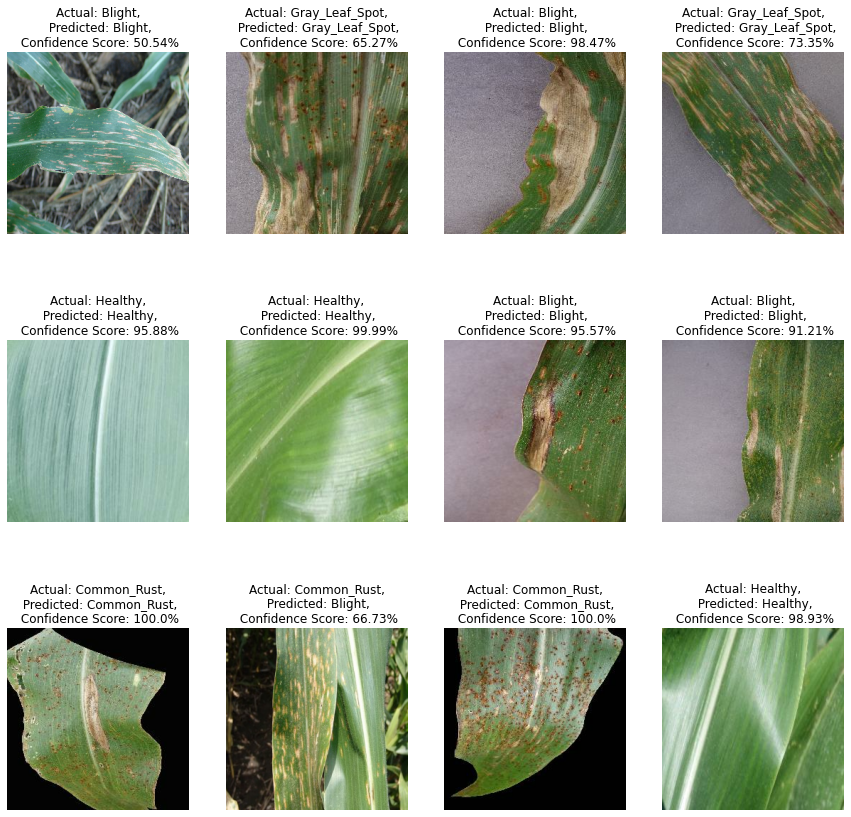

In [39]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class , confidence = predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence Score: {confidence}%")
        plt.axis("off")

In [40]:
model.save('Proyecto final/model_1')

INFO:tensorflow:Assets written to: Proyecto final/model_1\assets


INFO:tensorflow:Assets written to: Proyecto final/model_1\assets
